In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import pearsonr, spearmanr
import os

In [2]:
fol = '/Users/irffanalahi/Research/Research_update/SoftRD/largerEXP/genepromdelta.7/Randomforest/developing/onPBMC/corr/testAaronctprop/fixed_gt/CD8_combined/perct_corr/apply_bilgecode/RF_ctprop2_try3_cellname'

file_names = os.listdir(fol)

file_names.sort() 
print(file_names)

files = []
for file in file_names:
    files.append(fol + '/' + file)

if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')

if '.DS_Store' in files:
    files.remove('.DS_Store')

['a_method_RF_gt_flow(new)', 'a_method_RF_gt_flow(old)', 'c_method_RF_gt_CyTOF(new)', 'd_method_RF_gt_CyTOF(old)']


In [3]:
def generate_df_dic(correlation, df, columns):
    df_corr = {}
    df = df.loc[samples, :]
    for cell in columns:
        if cell in df.columns:
            corr = correlation(list(df[cell]), list(df[cell + '_real']))[0]
            df_corr[cell] = corr
        else:
            df_corr[cell] = float('NaN')
    return df_corr

def linear_reg(df, columns):
    df_reg = {}
    for cell in columns:
        if cell in df.columns:
            GT = np.array(df[cell + '_real'])
            RC = np.array(df[cell])
            df_reg[cell] = np.polyfit(GT, RC, 1)
    return df_reg

In [4]:
new_columns = []

for j, file in enumerate(files):
    data = pd.read_csv(file, sep='\t', index_col=0)
    df = pd.DataFrame(data)
    cols = []
    
    for cell in list(df.columns):
        if '.x' in cell:
            cols.append(cell.split('.')[0])
        elif '.y' in cell:
            cols.append(cell.split('.')[0] + '_real')
        else:
            cols.append(cell)
    df.columns = cols
    
    samples = list(df.index)
    columns = list(df.columns)
    for col in columns:
        if '_real' in col:
            new_columns.append(col.split('_')[0])
    
new_columns = list(set(new_columns))
print(new_columns)

['nB', 'm4', 'Mono', 'mB', 'Tr', 'NaiveCD4', 'DC', 'CD8', 'NK']


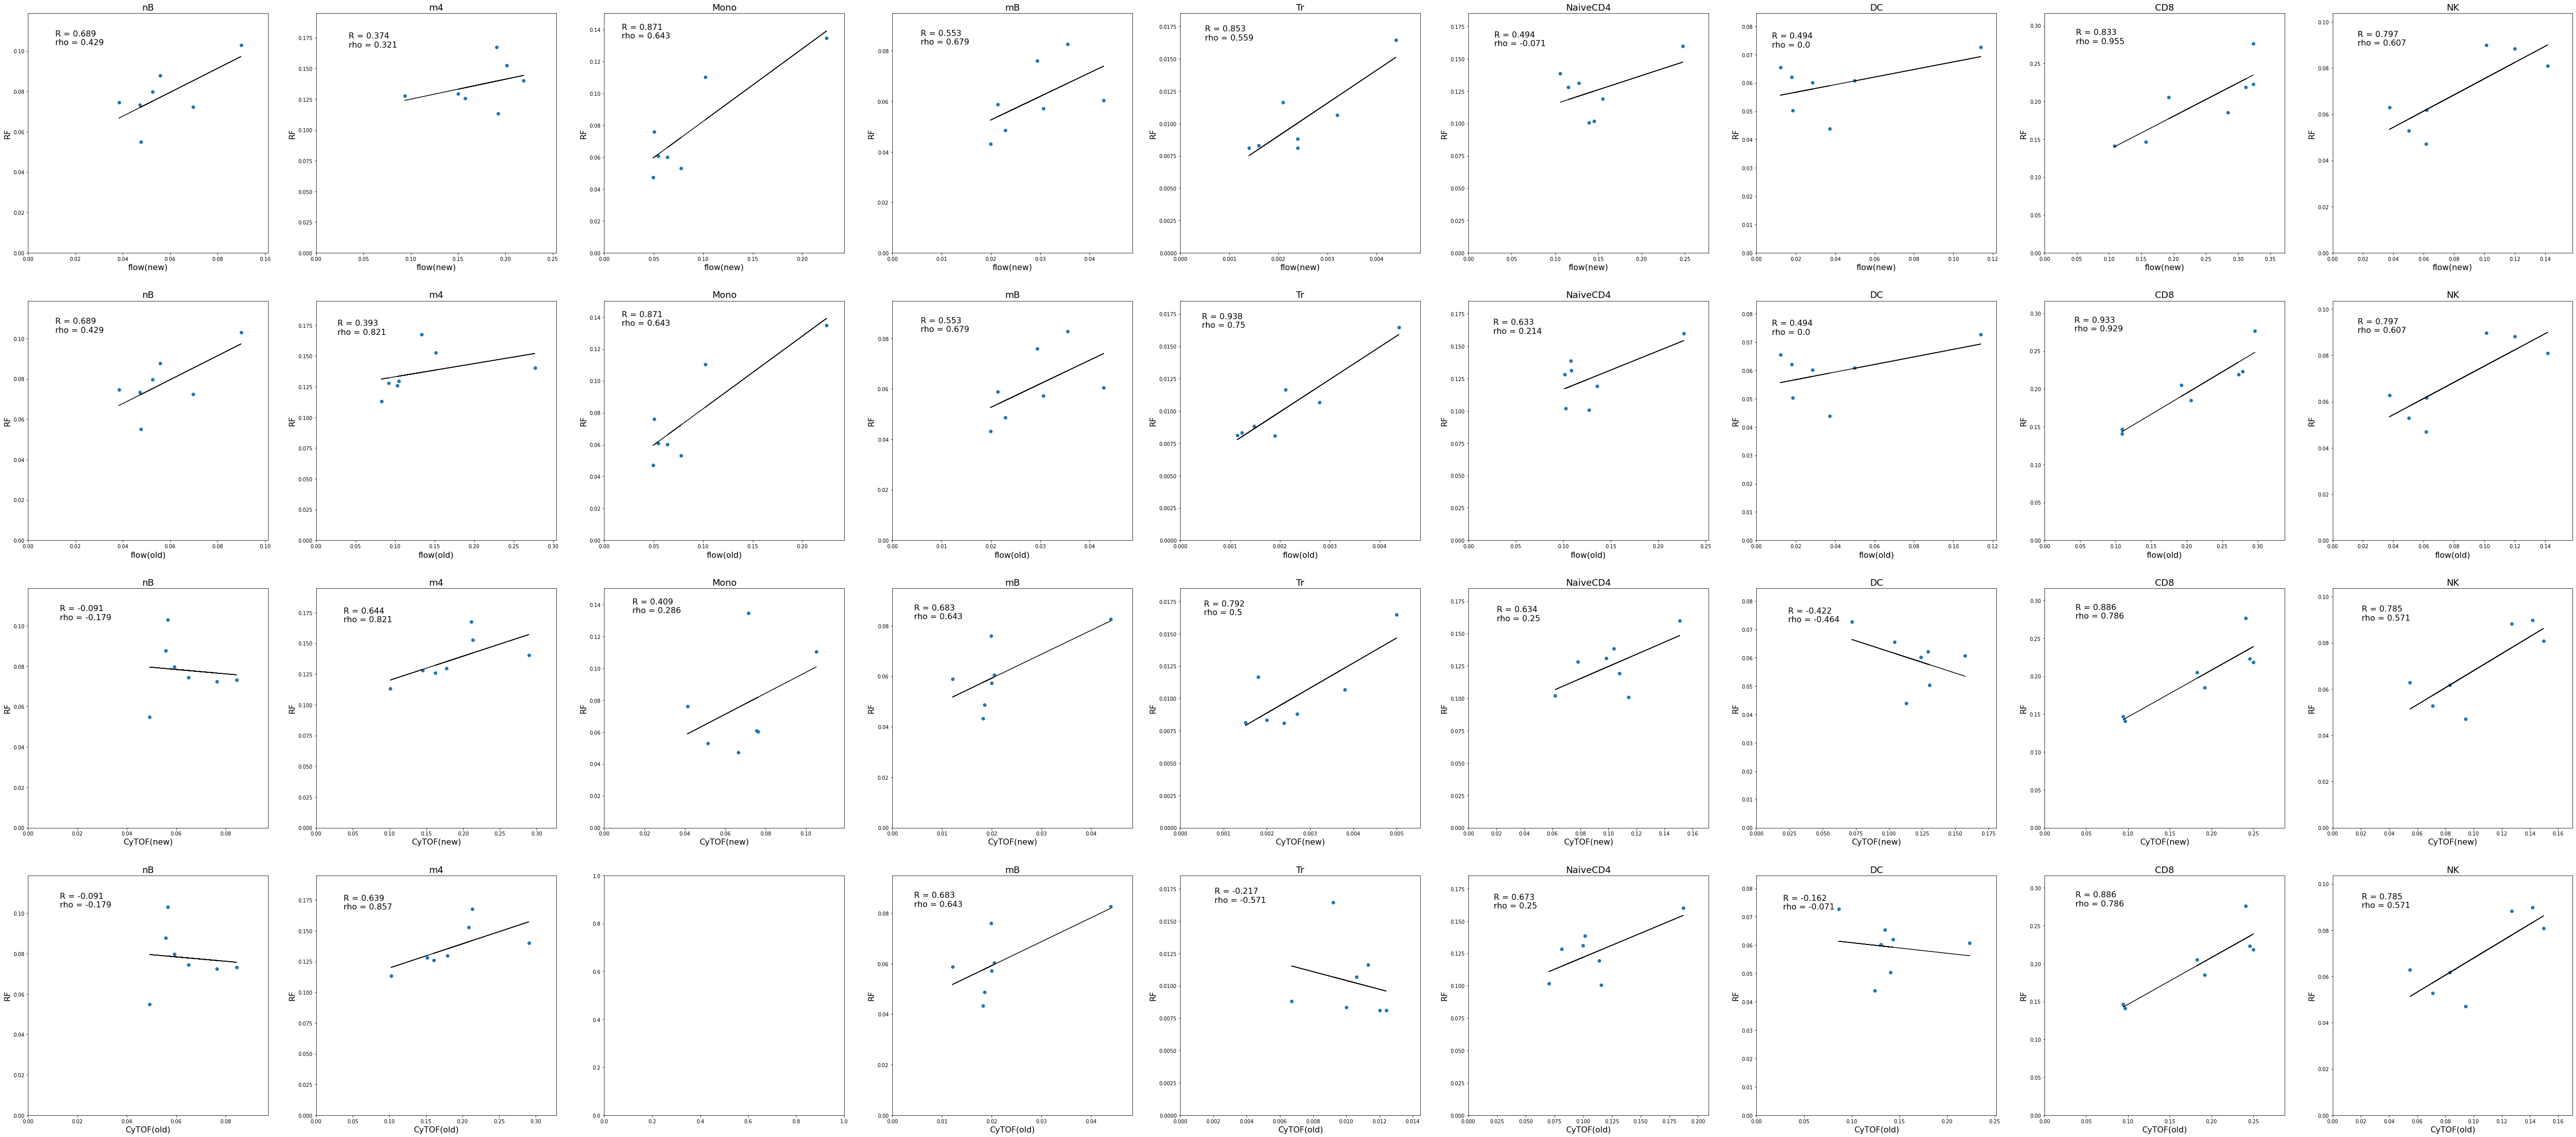

In [5]:
fig, axs = plt.subplots(len(files), len(new_columns), figsize=(len(new_columns) * 10, len(files) * 10))

for j, file in enumerate(files):
    data = pd.read_csv(file, sep='\t', index_col=0)
    df = pd.DataFrame(data)
    
    pearson_dic = generate_df_dic(pearsonr, df, new_columns)
    spearman_dic = generate_df_dic(spearmanr, df, new_columns)
    reg = linear_reg(df, new_columns)
    
    file_name = file.split('/')[-1].split('_')
    x_label_lst = []
    y_label_lst = []
    
    method_seen = False
    gt_seen = False
    
    for name in file_name:
        if name == 'method':
            method_seen = True
            continue
        elif name == 'gt':
            gt_seen = True
            continue 
            
        
        if (method_seen == True) and (gt_seen == False):
            if '.txt' in name:
                name = name[:-4]
            y_label_lst.append(name)
        elif gt_seen:
            if '.txt' in name:
                name = name[:-4]
            x_label_lst.append(name)
        
        if name == 'method':
            method_seen = True
        elif name == 'gt':
            gt_seen = True
            
    x_label = '_'.join(x_label_lst)
    y_label = '_'.join(y_label_lst)
    
    for i, cell in enumerate(new_columns):
        if np.isnan(pearson_dic[cell]):
            continue
        GT = np.array(df[cell + '_real'])
        RC = np.array(df[cell])
        axs[j][i].scatter(GT, RC)
        axs[j][i].set_xlim(0, max(GT) + np.mean(GT) / 5)
        axs[j][i].set_ylim(0, max(RC) + np.mean(RC) / 5)
        m = reg[cell][0]
        b = reg[cell][1]
        axs[j][i].plot(GT, GT * m + b, c='k')
        axs[j][i].set_xlabel(x_label, fontsize=16)
        axs[j][i].set_ylabel(y_label, fontsize=16)
        axs[j][i].set_title(cell, fontsize=18)
        corrs = 'R = ' + str(np.around(pearson_dic[cell], decimals=3)) + '\nrho = ' + str(np.around(spearman_dic[cell], decimals=3))
        axs[j][i].annotate(corrs, xy = (np.mean(GT) / 5, max(RC)), fontsize=16)
        
plt.savefig(fol + '_cellcorr.pdf', bbox_inches='tight')